In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
import itertools

species_color = {'Marmoset': "orange",
 'Human': "green",
 'Rhesus': "blue",
 'Chimpanzee': "red",
 'Capuchin': "brown"}

PYTHON_PATH = "/Users/rb4174/Documents/projects/brain_dev_primates/altricial_brain_vocal_learning"

def condition(column,low_percentil,high_percentil):
    result_min = all(a >= b for a, b in zip(column, low_percentil))
    result_max = all(a <= b for a, b in zip(column, high_percentil))

    if result_min and result_max:
        return True
    else:
        return False
         

/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_96088/1719168657.py:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
df_fits = pd.read_pickle("{0}/data/derivatives_with_error.pkl".format(PYTHON_PATH)) 
df_events = pd.read_excel("{0}/data/developmental_stages_events.xlsx".format(PYTHON_PATH),index_col=False)
species_list = ["Chimpanzee","Rhesus","Human","Marmoset"]

Chimpanzee
Rhesus
Human
Marmoset


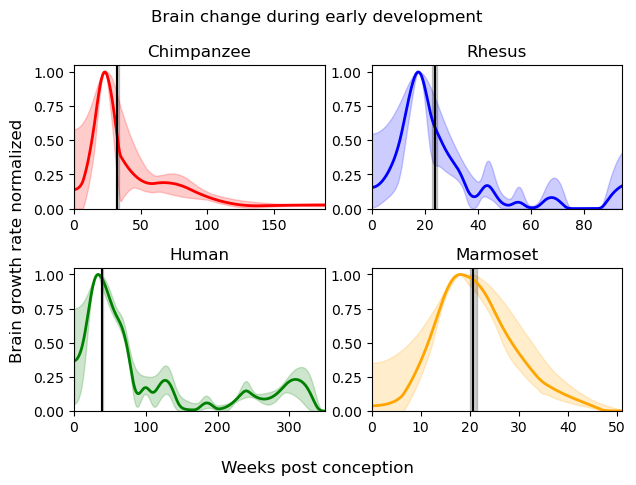

In [3]:
i = 0
derivative_data_species_all = {}
derivative_data_species_all_filtered = {}

derivative_fit = []
fig, ax = plt.subplots(nrows=2, ncols=2)

for row in ax:
    for col in row:
        specie = species_list[i]
        print(specie)
        df_fits_specie = df_fits[df_fits.specie == specie]
        df_event_specie = df_events[df_events.specie == specie]
        gestation_weeks = df_event_specie[df_event_specie.event == "gestation"]["avg_wkspc"].values[0]
        gestation_weeks_sd = df_event_specie[df_event_specie.event == "gestation"]["sd_(days)"].values[0]/7
        late_infancy_ends = df_event_specie[(df_event_specie.event == "dental_late_infancy_ends")]["avg_wkspc"].values[0]

        x = df_fits_specie["x_dydx"].item()
        y = df_fits_specie["y_dydx"].item()
        low_percentil = df_fits_specie["y_dydx_low_95Percentil"].item()
        high_percentil = df_fits_specie["y_dydx_max_95Percentil"].item()

        #Defining the distribution of rates in the birth interval, USING ALL
        df_derivative_all = {"weeks":x,"low_percentil":low_percentil,"high_percentil":high_percentil}
        for num, item in enumerate(df_fits_specie["all_y"].item()):
            df_derivative_all[num] = df_fits_specie["all_y"].item()[num]
            
        df_derivative_all = pd.DataFrame(df_derivative_all)
        derivative_data_species_all[specie] = df_derivative_all[(df_derivative_all.weeks >= gestation_weeks - gestation_weeks_sd) & 
                                                        (df_derivative_all.weeks <= gestation_weeks + gestation_weeks_sd)]

        #Plot
        SIGMA = {'Marmoset': 1,'Human': 10,'Rhesus': 10, 'Chimpanzee': 1}

        y = gaussian_filter1d(y,sigma = SIGMA[specie])
        low_percentil = gaussian_filter1d(low_percentil,sigma = SIGMA[specie])
        high_percentil = gaussian_filter1d(high_percentil,sigma = SIGMA[specie])

        y = y/np.max(y)
        low_percentil = low_percentil/np.max(low_percentil)
        high_percentil = high_percentil/np.max(high_percentil)

        col.plot(x,y, '-', color = species_color[specie],linewidth = 2)
        col.fill_between(x, low_percentil, high_percentil, color=species_color[specie], alpha=0.2)

        col.axvline(x = gestation_weeks, color = "black",linestyle = '-')
        col.axvspan(gestation_weeks - gestation_weeks_sd, gestation_weeks + gestation_weeks_sd, alpha=0.2, color='black')
        
        xlim = late_infancy_ends
        if specie == "Marmoset":
            xlim = 50
        col.set_xlim(0,xlim + 1)
        col.set_title(specie)
        col.set_ylim(bottom=0)
        i += 1

fig.supxlabel('Weeks post conception') 
fig.supylabel('Brain growth rate normalized')
fig.suptitle("Brain change during early development")
fig.tight_layout()
fig.savefig("{0}/figs/2B.pdf".format(PYTHON_PATH),dpi = 800)
plt.show()

/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_96088/1505509260.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(x="specie", y="possible_values", data=boxplot_df, width=0.3,


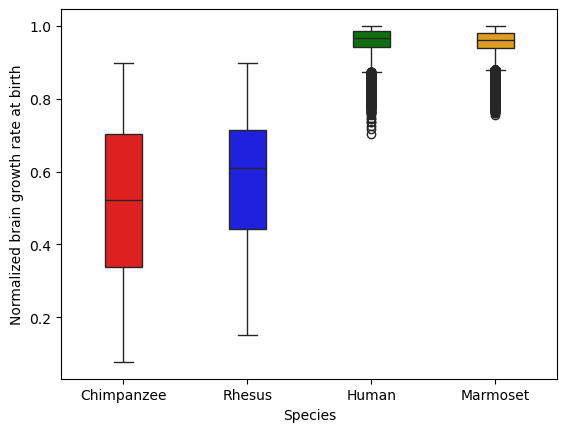

In [4]:
boxplot_df_all = {"specie":[],"possible_values":[]}
for species in df_fits["specie"].unique():
    all_values = []
    species_all_dist = derivative_data_species_all[species]
    for column in species_all_dist.columns:
        if column != "weeks":
            all_values.extend(species_all_dist[column])
    boxplot_df_all["possible_values"].extend(all_values)
    boxplot_df_all["specie"].extend(len(all_values)*[species])

boxplot_df = pd.DataFrame(boxplot_df_all)

g = sns.boxplot(x="specie", y="possible_values", data=boxplot_df, width=0.3, 
            order = ["Chimpanzee","Rhesus","Human","Marmoset"],
            palette=["red","blue","green","orange"])

g.set_xlabel("Species")
g.set_ylabel("Normalized brain growth rate at birth")
plt.savefig("{0}/figs/2C.pdf".format(PYTHON_PATH),dpi = 800)


## Calculating confidence interval of the mean of the distributions

In [10]:
# Number of bootstrap samples
n_bootstrap_samples = 1000
confidence_level = 0.95

for species in derivative_data_species_all.keys():
    data = boxplot_df[boxplot_df.specie == species]["possible_values"]
    # Array to store bootstrap means
    bootstrap_means = np.zeros(n_bootstrap_samples)

    # Perform bootstrap resampling
    for i in range(n_bootstrap_samples):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    lower_percentile = (1 - confidence_level) / 2
    upper_percentile = 1 - lower_percentile
    confidence_interval = np.percentile(bootstrap_means, [100 * lower_percentile, 100 * upper_percentile])

    mean = np.mean(data)
    median = np.median(data)
    max_value = np.max(data)
    min_value = np.min(data)

    print(species)
    print(f"Mean: {mean}")
    print(f"95% Confidence Interval: {confidence_interval}")
    print(f"Median: {mean}")
    print(f"Max: {max_value}")
    print(f"Min: {min_value}")


    print()

Chimpanzee
Mean: 0.5163382891567726
95% Confidence Interval: [0.51509436 0.51766307]
Median: 0.5163382891567726
Max: 0.8995164487455118
Min: 0.07748634172093778

Rhesus
Mean: 0.5845274429461461
95% Confidence Interval: [0.58368785 0.585303  ]
Median: 0.5845274429461461
Max: 0.8991645515353455
Min: 0.1512652028771087

Human
Mean: 0.9555098955207912
95% Confidence Interval: [0.95491297 0.95620485]
Median: 0.9555098955207912
Max: 0.9987052640658858
Min: 0.704015816378237

Marmoset
Mean: 0.9547225055911505
95% Confidence Interval: [0.95455956 0.95488009]
Median: 0.9547225055911505
Max: 1.0
Min: 0.756110305057173



# percentil bonds of the distributions

In [6]:
percentil = 0.95

for species in derivative_data_species_all.keys():

    lower_percentile = (1 - percentil) / 2
    upper_percentile = 1 - lower_percentile
    data = boxplot_df[boxplot_df.specie == species]["possible_values"]
    confidence_interval = np.percentile(data, [100 * lower_percentile, 100 * upper_percentile])

    mean = np.mean(data)

    print(species)
    print(f"Mean: {mean}")
    print(f"95% Percentil bounds: {confidence_interval}")
    print()

Chimpanzee
Mean: 0.5163382891567726
95% Percentil bounds: [0.15391124 0.83880735]

Rhesus
Mean: 0.5845274429461461
95% Percentil bounds: [0.29174713 0.83459255]

Human
Mean: 0.9555098955207912
95% Percentil bounds: [0.83907003 0.99639639]

Marmoset
Mean: 0.9547225055911505
95% Percentil bounds: [0.85707309 0.99864588]



## Stats tests of the distributions

In [7]:
from scipy.stats import anderson_ksamp #wilcoxon

list_species = ["Marmoset","Human","Rhesus","Chimpanzee",]

for pair in itertools.combinations(list_species, 2):
    ad_stat, critical_values, significance_level = anderson_ksamp([boxplot_df[boxplot_df.specie == pair[0]]["possible_values"],
                        boxplot_df[boxplot_df.specie == pair[1]]["possible_values"]])
    print(pair[0],pair[1],ad_stat, critical_values, significance_level)

Marmoset Human 228.26269115049112 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001


/var/folders/ys/4vmt6skn47v69q7dptm_7p3m0000gp/T/ipykernel_96088/1847351901.py:6: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat, critical_values, significance_level = anderson_ksamp([boxplot_df[boxplot_df.specie == pair[0]]["possible_values"],


Marmoset Rhesus 156175.2259367792 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001
Marmoset Chimpanzee 132513.85394537193 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001
Human Rhesus 42907.89473988957 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001
Human Chimpanzee 37906.944584362456 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001
Rhesus Chimpanzee 6855.522676006358 [0.325 1.226 1.961 2.718 3.752 4.592 6.546] 0.001


In [8]:
from scipy.stats import mannwhitneyu

#is a nonparametric test of the null hypothesis that, for randomly selected values X and Y from two populations,
#the probability of X being greater than Y is equal to the probability of Y being greater than X.

for pair in itertools.combinations(list_species, 2):
    if (pair[0] == "Marmoset" and pair[1] == "Human") or (pair[0] == "Rhesus" and pair[1] == "Chimpanzee"):
        alternative = "two-sided"
    else:
        alternative = "greater"

    u, p = mannwhitneyu(boxplot_df[boxplot_df.specie == pair[0]]["possible_values"],
                        boxplot_df[boxplot_df.specie == pair[1]]["possible_values"],alternative = alternative)
    print(pair[0],pair[1],u, p)


Marmoset Human 1303488703.0 2.945512217864104e-35
Marmoset Rhesus 23876902462.0 0.0
Marmoset Chimpanzee 17395821410.0 0.0
Human Rhesus 2335610183.0 0.0
Human Chimpanzee 1701362953.0 0.0
Rhesus Chimpanzee 8717753739.0 0.0


In [9]:
from scipy.stats import ks_2samp

list_species = ["Marmoset","Human","Rhesus","Chimpanzee",]

for pair in itertools.combinations(list_species, 2):
    ks_stat, p = ks_2samp(boxplot_df[boxplot_df.specie == pair[0]]["possible_values"],
                        boxplot_df[boxplot_df.specie == pair[1]]["possible_values"])
    print(pair[0],pair[1],ks_stat, p)


Marmoset Human 0.0842074592074592 5.893865176671868e-93
Marmoset Rhesus 0.972097054726589 0.0
Marmoset Chimpanzee 0.9667628690025785 0.0
Human Rhesus 0.9569318574522415 0.0
Human Chimpanzee 0.9513340279511154 0.0
Rhesus Chimpanzee 0.19342259797978067 0.0
